# SD701 - TP3 :  Forest Type Prediction

## I. Load Data & Data Exploration

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import math as m
import seaborn as sns
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df_train = pd.read_csv("/Users/mathieubruniquel/Desktop/MS BGD/3. Cours/SD 701 - Exploration grand volumes de données/2. TP/TP3/Data/train-set.csv")
df_submit = pd.read_csv("/Users/mathieubruniquel/Desktop/MS BGD/3. Cours/SD 701 - Exploration grand volumes de données/2. TP/TP3/Data/test-set.csv")

### Outliers search

In [3]:
columns = list(df_train.columns)
coltoplot = columns[1:11]
coltoplot.append(columns[-1])
Label_classes = df_train.Cover_Type.unique()
Label_classes = np.sort(Label_classes)

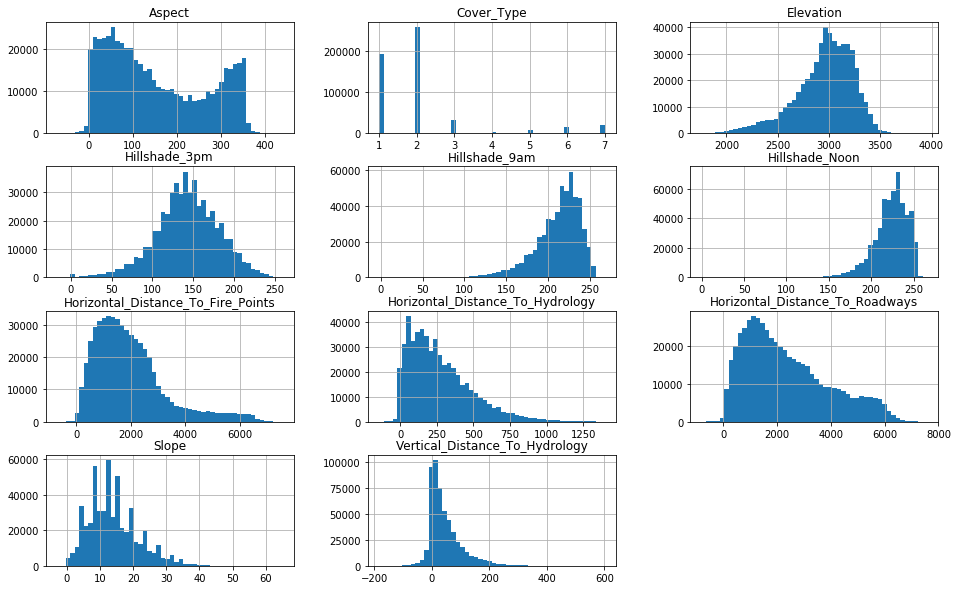

In [4]:
# Plot of non dummy features
df_train[coltoplot].hist(figsize=(16,10), bins=50)
plt.show()

** It can be noticed that there are several surprising negative values for the features below **

- "Horizontal Distance To Hydrology"
- "Horizontal Distance To Roadways"
- "Horizontal Distance To Fire Points"
- 'Vertical_Distance_To_Hydrology'
- "Slope"
- "Aspect"
- "9am hillshade"
- "3pm hillshade"


**Focus on the 4 first features**


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


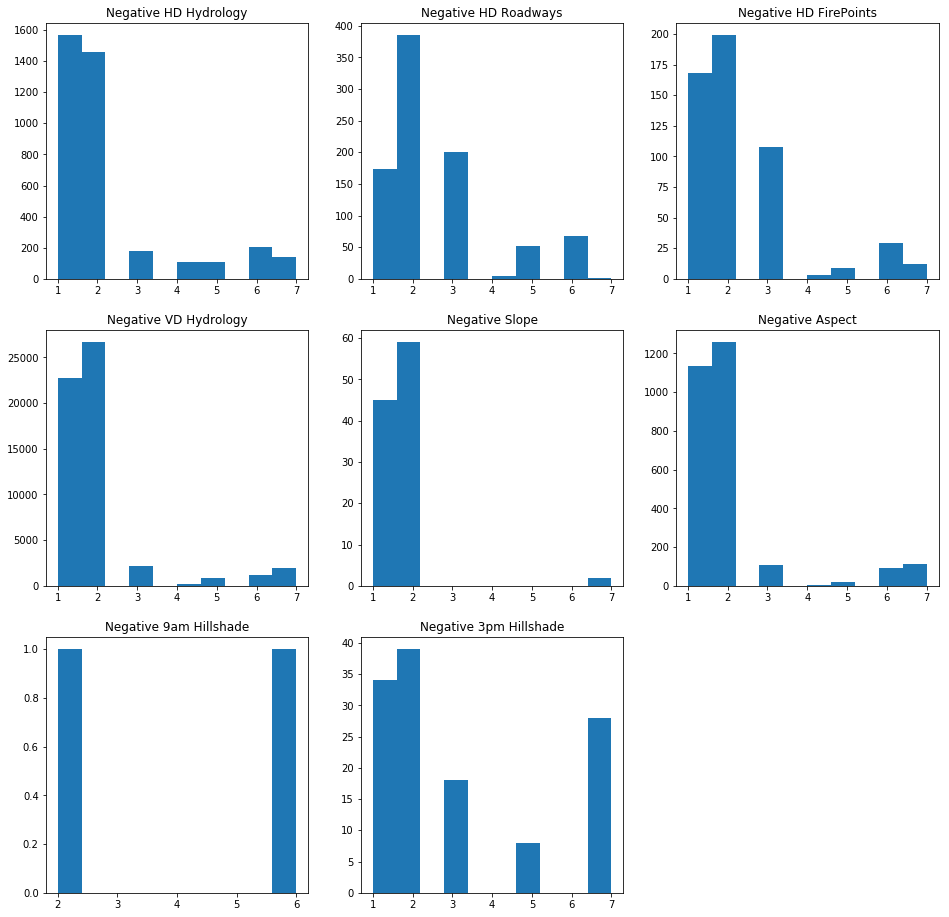

In [5]:
fig1 = plt.figure(1, figsize=(16,16))

plt.subplot(331)
plt.title('Negative HD Hydrology')
plt.hist(df_train[df_train['Horizontal_Distance_To_Hydrology']<0]['Cover_Type'])

plt.subplot(332)
plt.title('Negative HD Roadways')
plt.hist(df_train[df_train['Horizontal_Distance_To_Roadways']<0]['Cover_Type'])

plt.subplot(333)
plt.title('Negative HD FirePoints')
plt.hist(df_train[df_train['Horizontal_Distance_To_Fire_Points']<0]['Cover_Type'])

plt.subplot(334)
plt.title('Negative VD Hydrology')
plt.hist(df_train[df_train['Vertical_Distance_To_Hydrology']<0]['Cover_Type'])

plt.subplot(335)
plt.title('Negative Slope')
plt.hist(df_train[df_train['Slope']<0]['Cover_Type'])

plt.subplot(336)
plt.title('Negative Aspect')
plt.hist(df_train[df_train['Aspect']<0]['Cover_Type'])

plt.subplot(337)
plt.title('Negative 9am Hillshade')
plt.hist(df_train[df_train['Hillshade_9am']<0]['Cover_Type'])

plt.subplot(338)
plt.title('Negative 3pm Hillshade')
plt.hist(df_train[df_train['Hillshade_3pm']<0]['Cover_Type'])

fig1.show()

**Looking at the submission dataset for the same values and features**

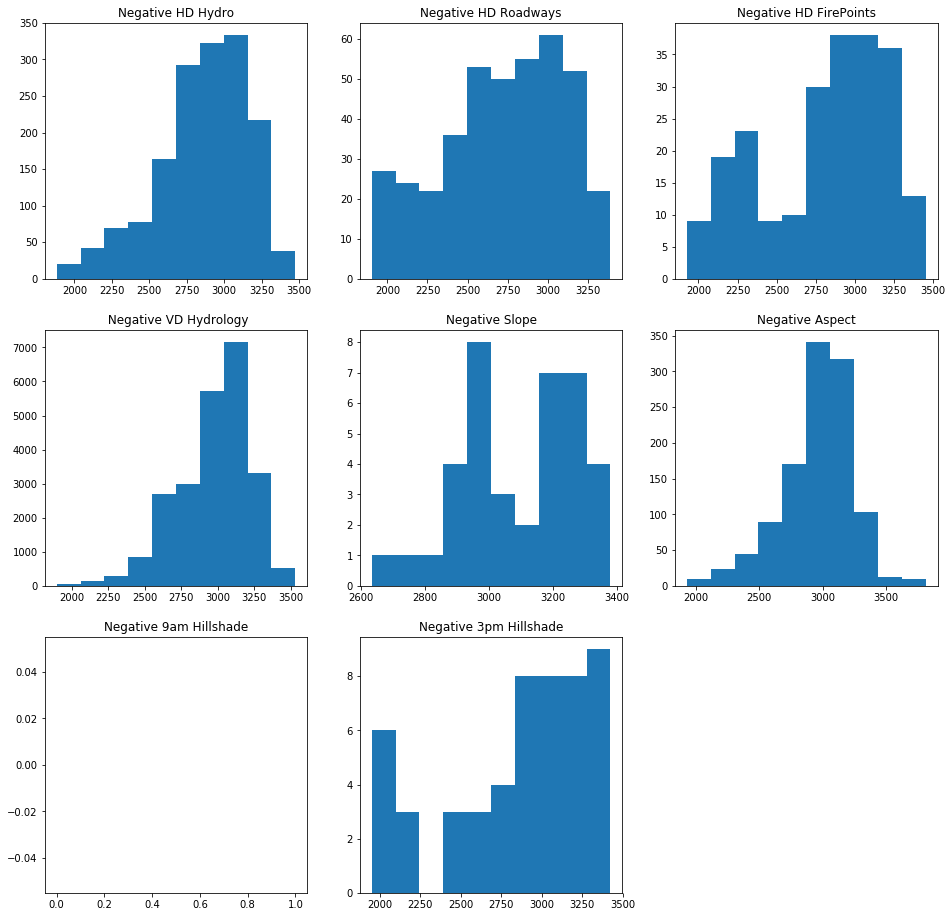

In [6]:
fig1 = plt.figure(1, figsize=(16,16))

plt.subplot(331)
plt.hist(df_submit[df_submit['Horizontal_Distance_To_Hydrology']<0]['Elevation'])
plt.title("Negative HD Hydro")

plt.subplot(332)
plt.hist(df_submit[df_submit['Horizontal_Distance_To_Roadways']<0]['Elevation'])
plt.title("Negative HD Roadways")

plt.subplot(333)
plt.hist(df_submit[df_submit['Horizontal_Distance_To_Fire_Points']<0]['Elevation'])
plt.title("Negative HD FirePoints")

plt.subplot(334)
plt.hist(df_submit[df_submit['Vertical_Distance_To_Hydrology']<0]['Elevation'])
plt.title(" Negative VD Hydrology")

plt.subplot(335)
plt.hist(df_submit[df_submit['Slope']<0]['Elevation'])
plt.title("Negative Slope")

plt.subplot(336)
plt.hist(df_submit[df_submit['Aspect']<0]['Elevation'])
plt.title("Negative Aspect")

plt.subplot(337)
plt.title('Negative 9am Hillshade')
plt.hist(df_submit[df_submit['Hillshade_9am']<0]['Elevation'])

plt.subplot(338)
plt.title('Negative 3pm Hillshade')
plt.hist(df_submit[df_submit['Hillshade_3pm']<0]['Elevation'])

plt.show()

** Conclusions**

- There are very few observations with a negative 9Am Hillshade in the train dataset and none in the testset : they are probably outliers so let's remove these points
- There are many observations with negative values for all others features in both train and test set, so let's keep them for the moment

In [10]:
df_train = df_train[df_train['Hillshade_9am']>0]

## II. First models

### Defining function to plot Confusion Matrix

In [11]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Spliting the train dataset to test and select the different models

In [12]:
features = df_train.drop(['Id','Cover_Type'], 1)
feature_list = list(features.columns)
labels = df_train['Cover_Type']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)

### Logistic Regression

In [13]:
# Fit, training and score on the test set
classifier_log = lm.LogisticRegression()
log1 = classifier_log.fit(train_features, train_labels)
test_pred_log1 = log1.predict(test_features)
log1.score(test_features, test_labels)

0.7042830258267687

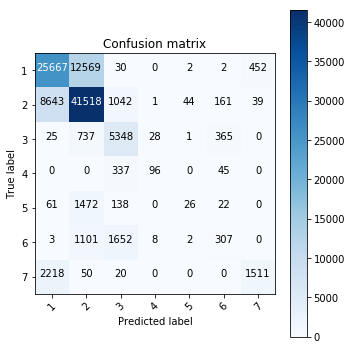

In [14]:
# Ploting the confusion matrix (cm)
cm_log = confusion_matrix(test_labels,test_pred_log1)

plt.figure(figsize=(5,5))
plot_confusion_matrix(cm_log, classes=np.sort(df_train.Cover_Type.unique()),
                      title='Confusion matrix')

### Random Forest

#### 10 trees


In [15]:
# Fit, training and score on the test set
rf0 = RandomForestClassifier(n_estimators = 10)
rf0.fit(train_features, train_labels)
test_pred_rf0 = rf0.predict(test_features)
rf0.score(test_features, test_labels)

0.9206756002761413

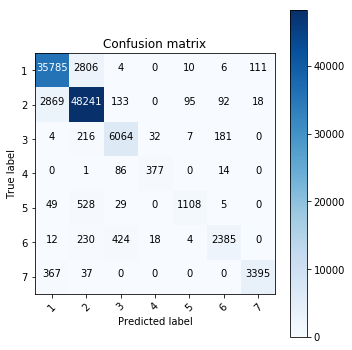

In [16]:
# Ploting the confusion matrix (cm)
cm_rf0 = confusion_matrix(test_labels, test_pred_rf0)
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm_rf0, classes=np.sort(df_train.Cover_Type.unique()),
                      title='Confusion matrix')

#### 100 trees

In [17]:
# Fit, training and score on the test set
rf1 = RandomForestClassifier(n_estimators = 100)
rf1.fit(train_features, train_labels)
test_pred_rf1 = rf1.predict(test_features)
rf1.score(test_features, test_labels)

0.9359673926406477

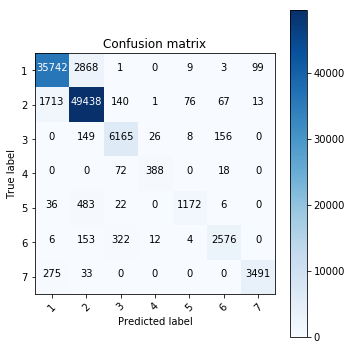

In [18]:
# Plot of confusion matrix (cm)
cm_rf1 = confusion_matrix(test_labels, test_pred_rf1)
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm_rf1, classes=np.sort(df_train.Cover_Type.unique()),
                      title='Confusion matrix')

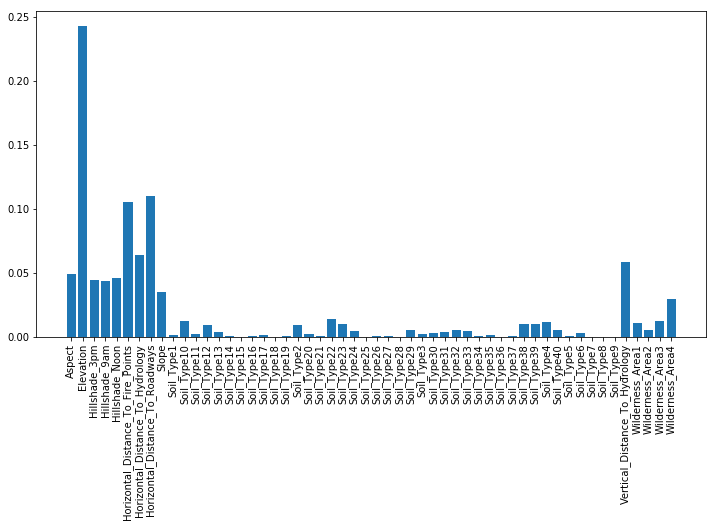

In [19]:
# Looking at the importance of the features in the model
plt.figure(figsize=(12,6))
plt.bar(features.columns,rf1.feature_importances_)
plt.xticks(rotation=90)
plt.show()

### Extra Trees

In order to compare extra tree models with random forest, let's build a first model with same number of estimators than the previous random forest model (ntrees=100)'

#### 100 trees 

In [20]:
# Fit, training and score on the test set
eTree = ExtraTreesClassifier(n_estimators=100, criterion='entropy')
eTree.fit(train_features, train_labels)
test_pred_etree = eTree.predict(test_features)
eTree.score(test_features, test_labels)

0.938303244659221

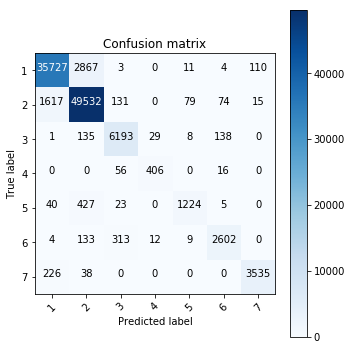

In [21]:
# Plot of confusion matrix (cm)
cm_eTree = confusion_matrix(test_labels, test_pred_etree)
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm_eTree, classes=np.sort(df_train.Cover_Type.unique()),
                      title='Confusion matrix')

### First Conclusions

**Extratree models perform better than the others.**

**Hence I decided to implement such models for the rest of our work and fine the best hyperparameters with cross validation**

## Searching deeper into the data

### Feature engineering

#### Creation of features

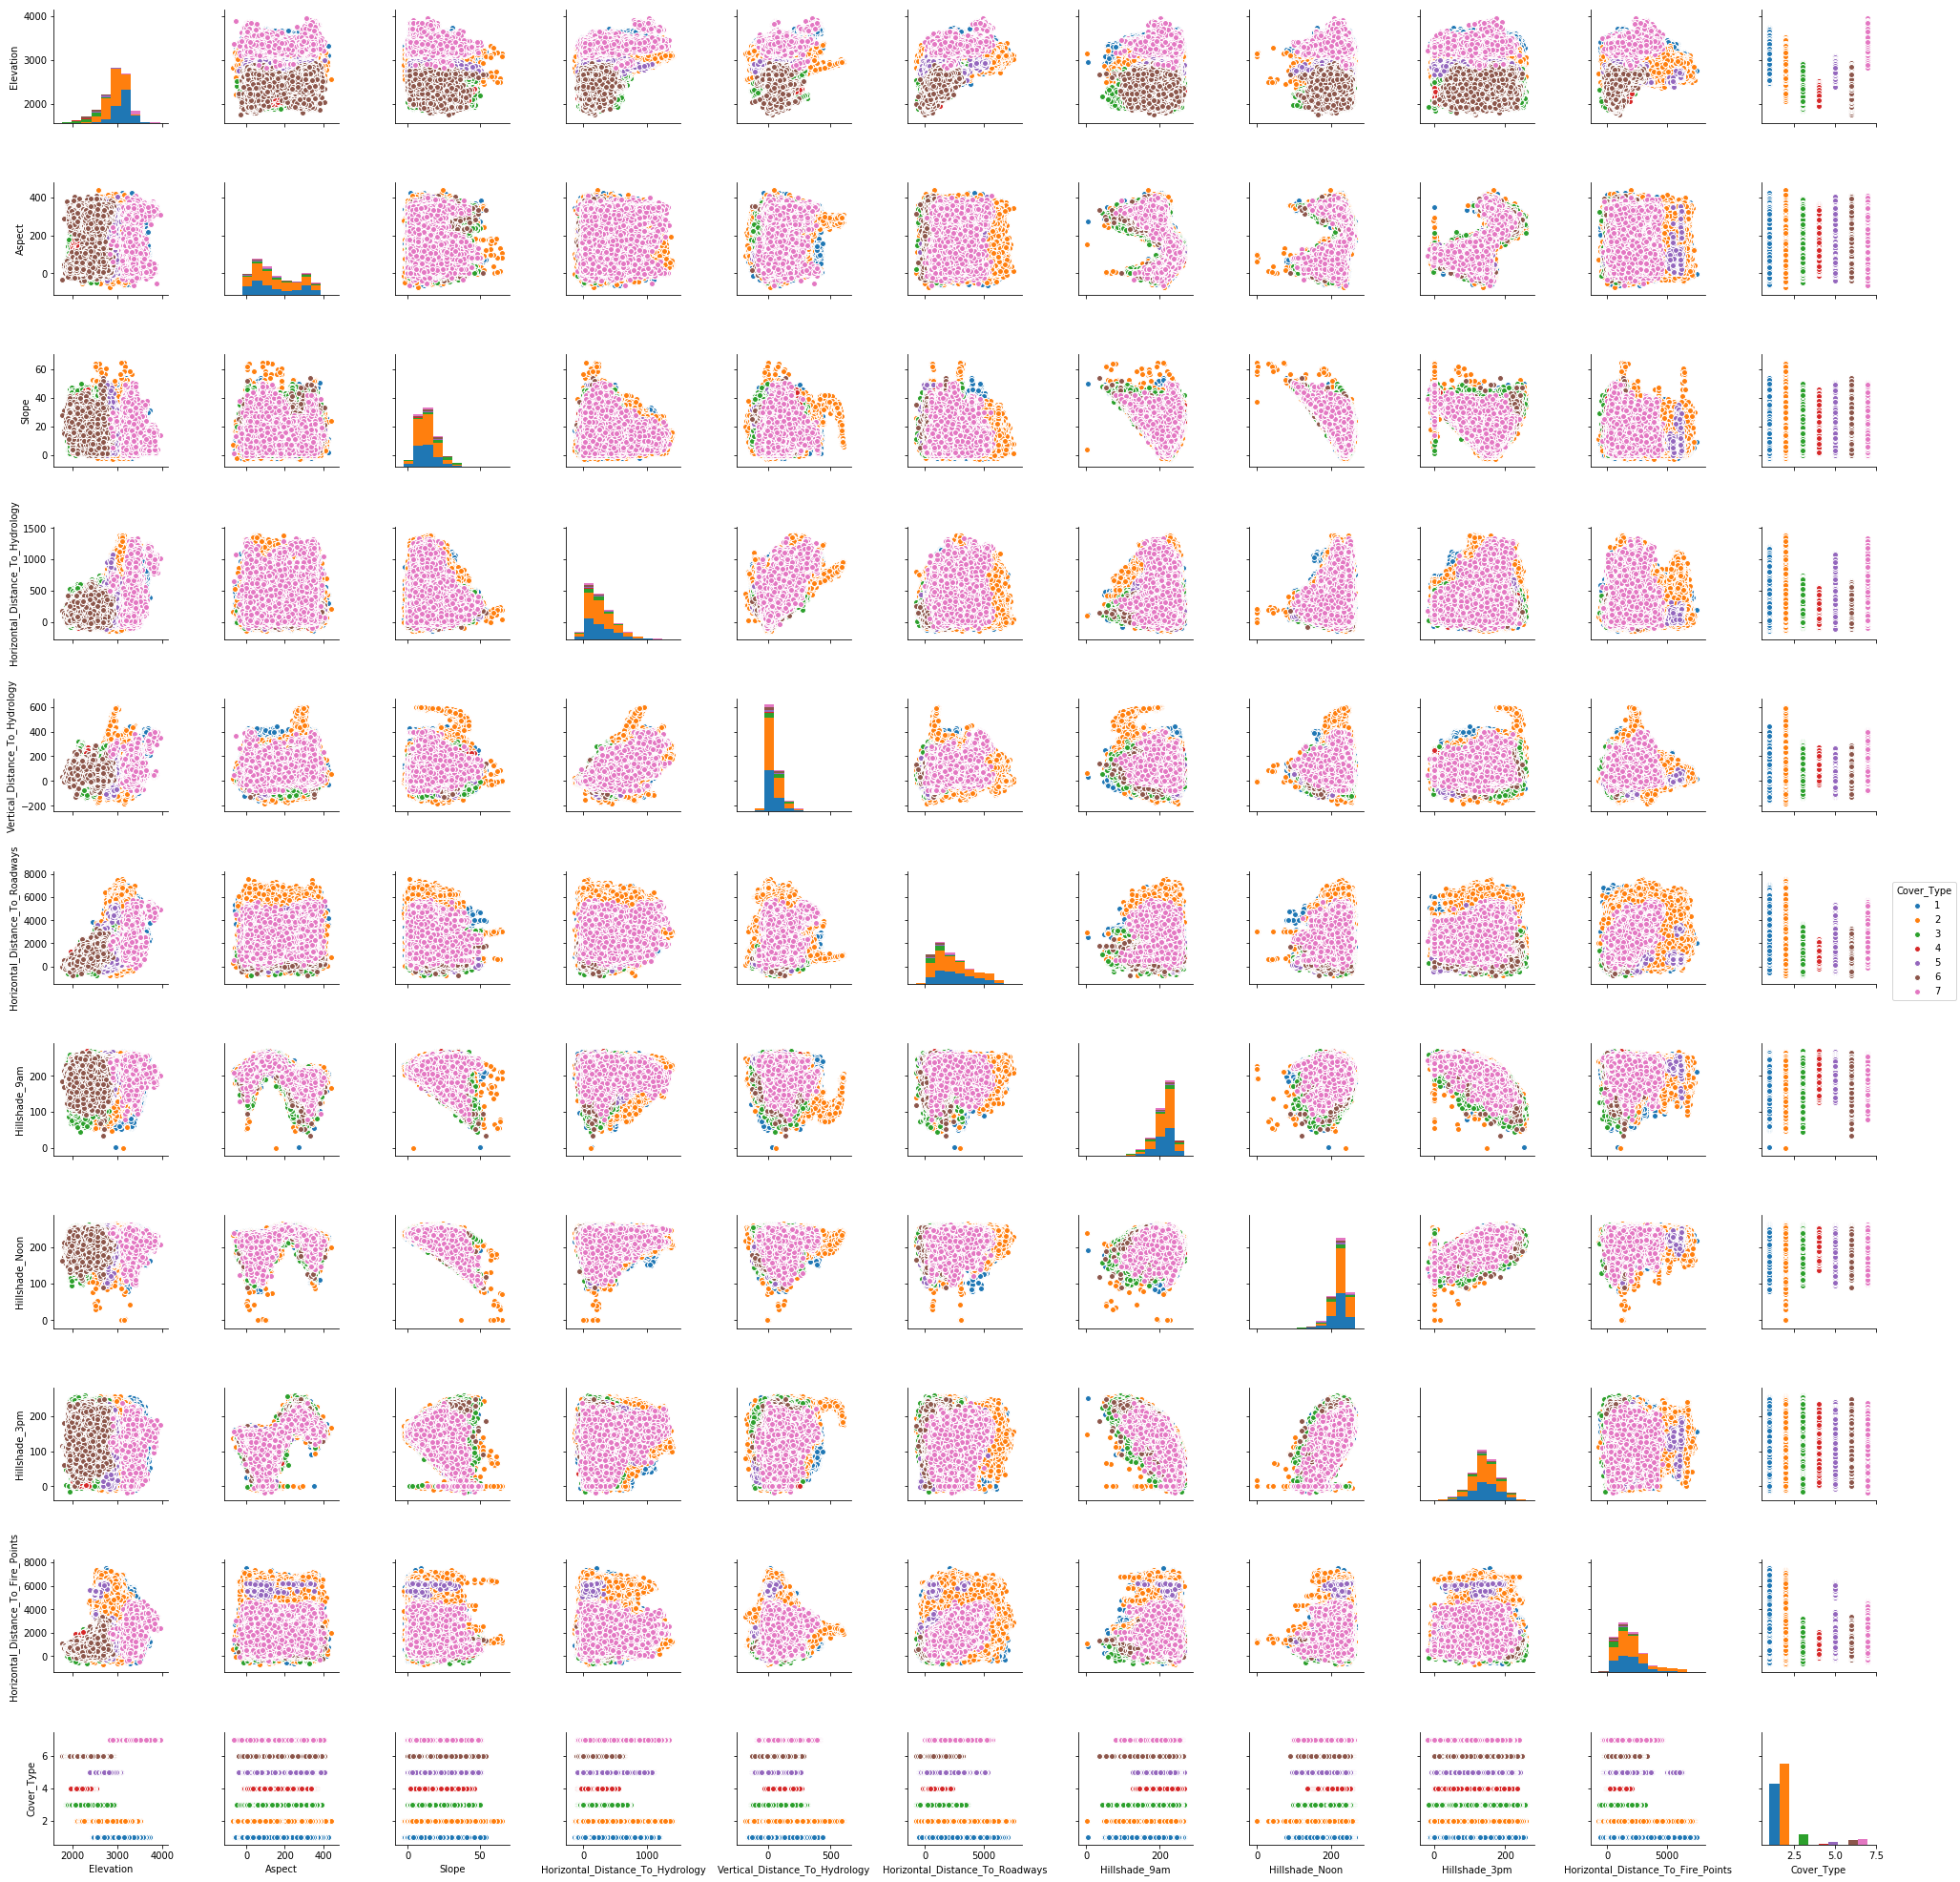

In [22]:
# Let's have a closer look to features and see how we could combine more relevant features
sns.pairplot(df_train, hue='Cover_Type', vars=coltoplot)

**First of all, common sense suggest we could combine horizontal and vertical distances to hydro point into the distance to hydro points**

In [23]:
# Feature creation
df_train['Distance_To_Hydro'] = df_train["Horizontal_Distance_To_Hydrology"]**2 + df_train["Vertical_Distance_To_Hydrology"]**2

In [24]:
# Creation of the df with newly created features
features = df_train.drop(['Id','Cover_Type'], 1)
feature_list = list(features.columns)
labels = df_train['Cover_Type']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)

#### Impact on performance

In [25]:
# Fit, training and score on the test set
eTree = ExtraTreesClassifier(n_estimators=100, criterion='entropy')
eTree.fit(train_features, train_labels)
test_pred_etree = eTree.predict(test_features)
eTree.score(test_features, test_labels)

0.9408282344930634

** As we can see, it improved the model performance, so we will keep this feature from now on**

### Changing "negative" observations

#### Transformation of the data

Let's try to reset the values of these observations using the average values of the observations with the same class

In [26]:
# Computation of the mean for these features for each cover_type
mean_Hill3pm = [df_train[df_train["Cover_Type"]==i]["Hillshade_3pm"].mean() for i in Label_classes]
mean_HDHydro = [df_train[df_train["Cover_Type"]==i]["Horizontal_Distance_To_Hydrology"].mean() for i in Label_classes]
mean_HDRoad = [df_train[df_train["Cover_Type"]==i]["Horizontal_Distance_To_Roadways"].mean() for i in Label_classes]
mean_HDFire = [df_train[df_train["Cover_Type"]==i]["Horizontal_Distance_To_Fire_Points"].mean() for i in Label_classes]
mean_VDHydro = [df_train[df_train["Cover_Type"]==i]["Vertical_Distance_To_Hydrology"].mean() for i in Label_classes]
mean_Slope = [df_train[df_train["Cover_Type"]==i]["Slope"].mean() for i in Label_classes]
mean_Aspect = [df_train[df_train["Cover_Type"]==i]["Aspect"].mean() for i in Label_classes]

**NB : Below you will notice I only do it on certain features as they form the combination of transformations that maximized the impact on the model performance**

In [27]:
df_train_original = df_train

In [28]:
# On the train set
df_train = df_train_original
for i, covertype in enumerate(Label_classes):
    #df_train['Hillshade_3pm'][(df_train["Hillshade_3pm"]<0) & (df_train["Cover_Type"]==covertype)] = [mean_Hill3pm[i]]*len(df_train[(df_train["Hillshade_3pm"]<0) & (df_train["Cover_Type"]==covertype)])
    df_train['Horizontal_Distance_To_Hydrology'][(df_train["Horizontal_Distance_To_Hydrology"]<0) & (df_train["Cover_Type"]==covertype)] = [mean_HDHydro[i]]*len(df_train[(df_train["Horizontal_Distance_To_Hydrology"]<0) & (df_train["Cover_Type"]==covertype)])
    #df_train['Horizontal_Distance_To_Roadways'][(df_train["Horizontal_Distance_To_Roadways"]<0) & (df_train["Cover_Type"]==covertype)] = [mean_HDRoad[i]]*len(df_train[(df_train["Horizontal_Distance_To_Roadways"]<0) & (df_train["Cover_Type"]==covertype)])
    #df_train['Horizontal_Distance_To_Fire_Points'][(df_train["Horizontal_Distance_To_Fire_Points"]<0) & (df_train["Cover_Type"]==covertype)] = [mean_HDFire[i]]*len(df_train[(df_train["Horizontal_Distance_To_Fire_Points"]<0) & (df_train["Cover_Type"]==covertype)])
    df_train['Vertical_Distance_To_Hydrology'][(df_train["Vertical_Distance_To_Hydrology"]<0) & (df_train["Cover_Type"]==covertype)] = [mean_VDHydro[i]]*len(df_train[(df_train["Vertical_Distance_To_Hydrology"]<0) & (df_train["Cover_Type"]==covertype)])
    df_train['Slope'][(df_train["Slope"]<0) & (df_train["Cover_Type"]==covertype)] = [mean_Slope[i]]*len(df_train[(df_train["Slope"]<0) & (df_train["Cover_Type"]==covertype)])
    df_train['Aspect'][(df_train["Aspect"]<0) & (df_train["Cover_Type"]==covertype)] = [mean_Aspect[i]]*len(df_train[(df_train["Aspect"]<0) & (df_train["Cover_Type"]==covertype)])

# Re-computing the new feature distance to Hydro after changing HD or VD Hydro
df_train['Distance_To_Hydro'] = df_train["Horizontal_Distance_To_Hydrology"]**2 + df_train["Vertical_Distance_To_Hydrology"]**2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopy

#### Impact on performance

In [29]:
# Creation of the df with newly created features
features = df_train.drop(['Id','Cover_Type'], 1)
feature_list = list(features.columns)
labels = df_train['Cover_Type']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [30]:
# Fit, training and score on the test set
eTree = ExtraTreesClassifier(n_estimators=400, max_depth=350, criterion='entropy', n_jobs=-1, bootstrap=False)
eTree.fit(train_features, train_labels)
test_pred_etree = eTree.predict(test_features)
eTree.score(test_features, test_labels)

0.9420292596200222

## Tuning Model with Hyperparameters selection

### Parameters Grid Definition

In [ ]:
# Number of trees 
n_estimators = [425, 450]

# Number of features to consider for a split
criterion = ['entropy']

# Maximum number of levels in tree
max_depth = [350, 400, 450]

# Bootstrap or not
bootstrap = [True, False]

In [ ]:
# Creation of parameters grid
grid_1 = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

### Grid Search

In [ ]:
# CV Random Search on 2 Folds
extree = ExtraTreesClassifier()
bestmodel = GridSearchCV(estimator = extree, param_grid = grid_1, cv = 2, n_jobs = -1)
bestmodel.fit(features, labels)
bestmodel.best_params_

## Predictions with best model

### Fit on the entire training set

In [11]:
#Fit of selected model on full training set
model_selec = ExtraTreesClassifier(n_estimators=450, max_depth=350, criterion='entropy', bootstrap=False, n_jobs=-1)
model_selec.fit(features, labels)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=350, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Transforming the submission dataset

In [12]:
df_submit = pd.read_csv("/Users/mathieubruniquel/Desktop/MS BGD/3. Cours/SD 701 - Exploration grand volumes de données/2. TP/TP3/Data/test-set.csv")
submit_id = pd.DataFrame(df_submit['Id'])
df_submit = df_submit.drop('Id',1)

for i, covertype in enumerate(Label_classes):
    #df_submit['Hillshade_3pm'][(df_submit["Hillshade_3pm"]<0)] = [df_submit["Hillshade_3pm"].mean()]*len(df_submit[(df_submit["Hillshade_3pm"]<0)])
    df_submit['Horizontal_Distance_To_Hydrology'][(df_submit["Horizontal_Distance_To_Hydrology"]<0)] = [df_submit["Horizontal_Distance_To_Hydrology"].mean()]*len(df_submit[(df_submit["Horizontal_Distance_To_Hydrology"]<0)])
    #df_submit['Horizontal_Distance_To_Roadways'][(df_submit["Horizontal_Distance_To_Roadways"]<0) ] = [df_submit["Horizontal_Distance_To_Roadways"].mean()]*len(df_submit[(df_submit["Horizontal_Distance_To_Roadways"]<0)])
    #df_submit['Horizontal_Distance_To_Fire_Points'][(df_submit["Horizontal_Distance_To_Fire_Points"]<0)] = [df_submit["Horizontal_Distance_To_Fire_Points"].mean()]*len(df_submit[(df_submit["Horizontal_Distance_To_Fire_Points"]<0)])
    df_submit['Vertical_Distance_To_Hydrology'][(df_submit["Vertical_Distance_To_Hydrology"]<0)] = [df_submit["Vertical_Distance_To_Hydrology"].mean()]*len(df_submit[(df_submit["Vertical_Distance_To_Hydrology"]<0)])
    df_submit['Slope'][(df_submit["Slope"]<0)] = [df_submit["Slope"].mean()]*len(df_submit[(df_submit["Slope"]<0)])
    df_submit['Aspect'][(df_submit["Aspect"]<0)] = [df_submit["Aspect"].mean()]*len(df_submit[(df_submit["Aspect"]<0) ])

df_submit['Distance_To_Hydro'] = df_submit["Horizontal_Distance_To_Hydrology"]**2 + df_submit["Vertical_Distance_To_Hydrology"]**2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/si

In [13]:
# Casting the dataset into the kaggle format
kaggle_submit = model_selec.predict(df_submit)
kaggle_submit = pd.DataFrame(kaggle_submit)
kaggle_submit.columns = ['Cover_Type']
submission = submit_id.join(pd.DataFrame(kaggle_submit))

In [15]:
# Exraction to CSV file for submission
submission.to_csv('submission.csv', sep=',', index = False)